In [4]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

In [6]:
#ODCZYT DANYCH Z PLIKU

#Funkcja odczytująca dane z plików csv w folderze Data
def ReadData(name:str):
    df = pd.read_csv("Data/"+name,header=None, sep=' ')
    Tasks=[]
    buf=[]
    for i in range(df.shape[0]):
        buf.clear()
        buf.append(i+1)
        for j in range(df.shape[1]):
            buf.append(df.iloc[i,j].item())
        Tasks.append(buf.copy())
    return Tasks
    

In [2]:
#FUNKCJE POMOCNICZE

#Funkcja oblicza wartości funkcji celu dla danego zestawu zadań.
#Argumenty:
#           Tasks - Czasy wykonywania zadań reprezentowane przez listę dwuwymiarową.
#                   Pierwszy indeks oznacza numer zadania, natomiast drugi indeks 
#                   oznacza numer maszyny.
#Zwracane:
#           S     - Macierz czasów rozpoczęcia wykonywanych zadań na maszynach. 
#                   Indeksowana w sposób S[zadanie][maszyna]
#           C     - Macierz czasów zakończenia wykonywanych zadań na maszynach. 
#                   Indeksowana w sposób C[zadanie][maszyna]
#           Cmax  - Maksymalny czas wykonywania wszystkich zadań.
#Funkcja przy liczeniu pomija pierwszy element każdego wektora czasów zadań, ponieważ jest on
#zarezerwowany dla numeru zadania.
def Calc_CMax(Tasks:list):
    C=np.zeros([len(Tasks[0])-1, len(Tasks)])
    S=np.zeros([len(Tasks[0])-1, len(Tasks)])
    #i -  maszyna, j - zadanie
    for i in range(0, len(Tasks[0])-1):
        for j in range(0, len(Tasks)):
            S[i,j] = max(C[i,j-1], C[i-1,j])
            C[i,j] = S[i,j] + Tasks[j][i+1]
    return S.transpose(), C.transpose(), C.max()

#Funkcja zamienia miejscami 2 elementy listy
#Argumenty:
#           Tasks - Lista z elementami.
#           i, j  - Pozycje zamienianych argumentów na liście.
#Zwracane:
#           Tasks - Lista z zamienionymi elementami.
def Swap(Tasks:list, i:int, j:int):
    bufList=Tasks
    buffer1=Tasks[i]
    buffer2=Tasks[j]
    Tasks[i]=buffer2
    Tasks[j]=buffer1
    return bufList

#Funkcja służąca do zmniejszania zakazów na liście Tabu zrealizowanej w formie macierzy.
#Jej działanie polega na zmniejszeniu o jeden wartości większy od zera, co oznacza skrócenie
#zakazu danego ruchu.
#Argumenty:
#           Tabu - Macierz reprezentująca listę zakazów.
#Zwracane:
#           Tabu - Macierz zakazów ze zmniejszonymi ograniczeniami.
def TabuDecrement(Tabu):
    for i in range(Tabu.shape[0]):
        for j in range(Tabu.shape[1]):
            if Tabu[i,j] != 0:
                Tabu[i,j] += -1
    return Tabu

#Funkcja wyświetla permutację zadań (kolejność wykonywania zadań)
def PrintPermutation(Tasks:list):
    buffer=[]
    for i in range(len(Tasks)):
        buffer.append(Tasks[i][0])
    print(buffer)
    

In [11]:
#ALGORTYM NEH

#Funkcja pomocnicza dla algorytmu NEH. Ma zadanie obliczanie wag zadań, 
#czyli sumy czasów wykonywania zadania na wszystkich maszynach.
#Argumenty:
#       Tasks       - Czasy wykonywania zadań reprezentowane przez listę dwuwymiarową.
#                     Indeksowanie takie samo jak przy pozostałych algorytmach.
#Zwraca:
#        weights    - Lista wag zadań (kolejność taka sama jak dla zadań).
def CalculateWeights(Tasks:list):
    weights=[]
    for i in range(len(Tasks)):
        weights.append(np.array(Tasks[i][1:]).sum())
    return weights

#Funkcja za ma zadanie dodanie do aktualnej permutacji nowe zadanie w taki sposób,
# że wartość funkcji celu dla nowej permutacji będzie jak najmniejsza.
#Argumenty:
#       Tasks       - Aktualna permutacja
#       NewTasks    - Nowe zadanie
#Zwraca:
#       permutation - Znaleziona najlepsza permutacja
def FindBestPosition(Tasks:list, NewTask:list):
    permutation=[]
    bestPermutation=[]
    CMax=float('inf')
    bestCMax=float('inf')
    
    #Sprawdzenie każdej dowolnej pozycji
    for i in range(len(Tasks)+1):
        permutation.clear()
        
        #Utworzenie permutacji z zadaniem dodanym na konkretnej pozycji
        for j in range(len(Tasks)):
            if j==i:
                permutation.append(NewTask.copy())
            permutation.append(Tasks[j].copy())
        #WYJĄTEK nowe zadanie na końcu permutacji
        if i == (len(Tasks)):
            permutation.append(NewTask.copy())
        
        #Obliczenie wartości funkcji celu nowej permutacji
        S, C, CMax=Calc_CMax(permutation.copy())
        #Zapamiętanie najlpeszego rozwiązania
        if CMax < bestCMax:
            bestCMax=CMax
            bestPermutation=permutation.copy()
    
    return bestPermutation
  
#Implementacja algorytmu NEH, który ma za zadanie znalezienie jak najlepszej 
# permutacji wykonywania zadań dla problemu przepływowego.
#Argumenty:
#       Tasks       - Czasy wykonywania zadań reprezentowane przez listę dwuwymiarową.
#                     Pierwszy indeks oznacza numer zadania, natomiast drugi indeks 
#                     oznacza numer maszyny (wyjątek: pierwszy element każdego zadania to jego numer,
#                     a nie czas wykonywania na pierwszej maszynie).
#Zwraca:
#       permutation - Znaleziona permutacja.
def NEH(Tasks:list):
    permutation=[]
    #Obliczenie wag zadań
    listOfWeights=CalculateWeights(Tasks.copy())      
    
    #Sortowanie zadań
    zippedTasks = sorted(zip(listOfWeights, Tasks.copy()), key=lambda x: x[0], reverse=True)
    
    #Tworzenie najlepszej permutacji
    permutation.append(zippedTasks[0][1])
    for i in range(1, len(zippedTasks)):
        permutation=FindBestPosition(permutation.copy(), zippedTasks[i][1].copy())

    return permutation

(array([[   0.,   37.,  114.,  205.,  296.],
        [  37.,  114.,  205.,  296.,  303.],
        [  42.,  178.,  244.,  307.,  376.],
        [  50.,  244.,  307.,  376.,  475.],
        [  87.,  277.,  376.,  468.,  515.],
        [ 158.,  324.,  459.,  515.,  598.],
        [ 223.,  391.,  488.,  564.,  651.],
        [ 236.,  452.,  551.,  651.,  740.],
        [ 271.,  551.,  648.,  727.,  834.],
        [ 323.,  605.,  671.,  776.,  918.],
        [ 386.,  671.,  745.,  819., 1015.],
        [ 444.,  728.,  819.,  872., 1114.],
        [ 457.,  793.,  872.,  946., 1157.],
        [ 526.,  817.,  946., 1000., 1228.],
        [ 561.,  847., 1000., 1068., 1314.],
        [ 570.,  942., 1021., 1077., 1365.],
        [ 660.,  982., 1067., 1159., 1387.],
        [ 717., 1067., 1159., 1253., 1389.],
        [ 807., 1113., 1161., 1304., 1449.],
        [ 862., 1159., 1244., 1368., 1466.],
        [ 898., 1214., 1307., 1435., 1547.],
        [ 982., 1253., 1394., 1482., 1553.],
        [1

In [55]:
#ALGORYTM TABU SEARCH

# Pierwsza wersja algortymu tabu search. Zaimplementowano w niej listę zakazów (w postaci macierzy) 
# oraz funkcję aspiracji w postaci akceptowania zakazanego ruchu, gdy da on lepszą permutancję niż 
# aktualnie najlepsza.
# Argumenty:
#           Tasks       - Czasy wykonywania zadań reprezentowane przez listę dwuwymiarową.
#                       Pierwszy indeks oznacza numer zadania, natomiast drugi indeks 
#                       oznacza numer maszyny (wyjątek: pierwszy element każdego zadania to jego numer,
#                       a nie czas wykonywania na pierwszej maszynie).
#           epochs      - Maksymalna liczba powtórzeń algorytmu.
#           tabuValue   - Długość listy zakazów. Wartość definiuje przez ile kolejnych 
#                         przeszukiwań dany ruch będzie zakazany.
#           stopRepeat  - Liczba powtórzeń poszukiwań po której algorytm zostanie zatrzymany, 
#                         gdy nie zostanie znalezione lepsze rozwiązanie.
# Zwracane:
#           bestPermutation - Najlepsza znaleziona permutacja, która daje możliwe 
#                             jak najniższą wartość funkcji celu.
def TabuSearch(Tasks:list, epochs:int, tabuValue=7, stopRepeat=25, aspiration=False):

    
    #Inicjalizacja zmiennych
    tabu=np.zeros([len(Tasks), len(Tasks)])
    permutation=NEH(Tasks.copy())
    S, C, cmax = Calc_CMax(permutation.copy())
    bestPermutation=permutation.copy()
    bestCMax= cmax
    neighbours=[]
    repeat=0
    nn=0
    cmax_epochs=[]
    #Warunek stopu
    for n in range(epochs):
        repeat+=1
        
        #Zmniejszenie zakazów
        tabu = TabuDecrement(tabu)
        
        #Generowanie sąsiadów
        neighbours.clear()
        for i in range(len(Tasks)):
            for j in range(len(Tasks)):
                if(i is not j):
                    bufPermutation=Swap(permutation.copy(), i, j)
                    empty1, empty2, cmax=Calc_CMax(bufPermutation.copy())
                    buf=[i, j, cmax]
                    neighbours.append(buf.copy())
        #Sortowanie sąsiadów 
        neighbours=sorted(neighbours, key=lambda x: x[2])
        
        
        #Sprawdzanie listy tabu
        for k in range(len(neighbours)):
            i, j, cmax = neighbours[k]
            #Wybór dozwolonego ruchu
            if tabu[i,j]==0:
                tabu[i,j]=tabuValue
                tabu[j,i]=tabuValue
                permutation=Swap(permutation.copy(), i, j)
                if cmax<bestCMax:
                    bestCMax=cmax
                    bestPermutation=permutation.copy()
                    repeat=0
                break
            #Aspiracja - wykonujemy zakazany ruch, gdy da rozwiązanie lepsze niż najlepsze aktualnie znalezione
            elif cmax<bestCMax:
                if aspiration:
                    tabu[i,j]=tabuValue+1
                    tabu[j,i]=tabuValue+1
                    permutation=Swap(permutation.copy(), i, j)
                    bestCMax=cmax
                    bestPermutation=permutation.copy()
                    repeat=0
                    break
        cmax_epochs.append(cmax)
        #Sprawdzenie czy permutacja się powtarza
        
        if repeat==stopRepeat:
            print('stop')
            nn=n+1
            break
        
    #MOŻLIWE SPOSOBY KOŃCZENIA ALGORYTMU
    #-Określona liczba powtórzeń
    #-Zakończenie gdy znajdowana wartość funkcji celu się powtarza (średnio działa dla tego problemu)
    #-Kończenie gdy przez N powtórzeń nie znajdzie się lepsze rozwiązanie (Aktualnie zaimplementowane)
        
        
    #Zwrócenie najlepszego rozwiązania
    return bestPermutation.copy() , cmax_epochs #,nn
                

In [56]:
#BADANIE 1
#DOBÓR DŁUGOŚCI LISTY TABU
#Badanie ma na celu znalezienie jak najlepszej długości listy zakazu. 
# Na potrzeby tego wyłączono działanie funkcji aspiracji oraz ustalono liczbę powtórzen alogrytmu
'''
epochs=100
tabuValue= np.arange(12)+1
csv_file = open('Badania1.csv', 'w')
for i in range(1, 23):
    data = ReadData("data."+str(i))
    print("Przetwarzanie pliku data."+str(i))
    perm = NEH(data)
    S, C, cmax = Calc_CMax(perm)
    results = str(cmax)
    print("Algorytm NEH: Cmax="+str(cmax))
    for j in range(len(tabuValue)):
        perm = TabuSearch(data, 100, tabuValue[j], 0)
        S, C, cmax = Calc_CMax(perm)
        results += " "+str(cmax)
        print("Algorytm TabuSearch przy liście tabu o długości="+str(tabuValue[j])+" : Cmax="+str(cmax))
    csv_file.writelines(results+"\n")
    print(results)

csv_file.close()
'''

#WYNIK BADAŃ NAJLEPSZE EFEKTY DLA LISTY TABU O DŁUGOŚCI 7


'\nepochs=100\ntabuValue= np.arange(12)+1\ncsv_file = open(\'Badania1.csv\', \'w\')\nfor i in range(1, 23):\n    data = ReadData("data."+str(i))\n    print("Przetwarzanie pliku data."+str(i))\n    perm = NEH(data)\n    S, C, cmax = Calc_CMax(perm)\n    results = str(cmax)\n    print("Algorytm NEH: Cmax="+str(cmax))\n    for j in range(len(tabuValue)):\n        perm = TabuSearch(data, 100, tabuValue[j], 0)\n        S, C, cmax = Calc_CMax(perm)\n        results += " "+str(cmax)\n        print("Algorytm TabuSearch przy liście tabu o długości="+str(tabuValue[j])+" : Cmax="+str(cmax))\n    csv_file.writelines(results+"\n")\n    print(results)\n\ncsv_file.close()\n'

In [57]:
#BADANIE 2
#DOBÓR LICZBY POWTÓRZEŃ ALGORYTMU
#Badanie ma na celu wyznaczenie optymalnej wartości liczby powtórzeń algorytmu. 
# Pierwszą opcją jest z góry ustalona liczba powtórzeń, jednak jej minusem jest 
# trudność w oszacowaniu odpowiedniej liczby dla zestawu danych. Innym warunkiem 
# stopu może być brak znalezienia lepszego rozwiązania od dotychczasowego przez N 
# powtórzeń. W tym celu w tym badaniu sprawdzono jakie wartości N są najlepsze do 
# posiadanych zestawów danych. Podczas badania korzystano z wcześniej wyznaczonej 
# długości listy tabu i jednocześnie nie korzystano z funkcji aspiracji.

'''
epochs=1000
tabuValue=7
N= np.arange(36)+1

csv_file = open('Badania2.csv', 'w')
for i in range(1, 21):
    data = ReadData("data."+str(i))
    print("Przetwarzanie pliku data."+str(i))
    perm = NEH(data)
    S, C, cmax = Calc_CMax(perm)
    results = str(cmax)
    print("Algorytm NEH: Cmax="+str(cmax))
    for j in range(len(N)):
        perm, n= TabuSearch(data, epochs, tabuValue, N[j])
        S, C, cmax = Calc_CMax(perm)
        results += " "+str(cmax)+" "+str(n)
        print("Algorytm TabuSearch przy N="+str(N[j])+" : Cmax="+str(cmax)+" n= "+str(n))
    csv_file.writelines(results+"\n")
    print(results)

csv_file.close()
'''

#WYNIK BADAŃ: Najlepiej przyjmować liczbę powtórzeń algortmu >25


'\nepochs=1000\ntabuValue=7\nN= np.arange(36)+1\n\ncsv_file = open(\'Badania2.csv\', \'w\')\nfor i in range(1, 21):\n    data = ReadData("data."+str(i))\n    print("Przetwarzanie pliku data."+str(i))\n    perm = NEH(data)\n    S, C, cmax = Calc_CMax(perm)\n    results = str(cmax)\n    print("Algorytm NEH: Cmax="+str(cmax))\n    for j in range(len(N)):\n        perm, n= TabuSearch(data, epochs, tabuValue, N[j])\n        S, C, cmax = Calc_CMax(perm)\n        results += " "+str(cmax)+" "+str(n)\n        print("Algorytm TabuSearch przy N="+str(N[j])+" : Cmax="+str(cmax)+" n= "+str(n))\n    csv_file.writelines(results+"\n")\n    print(results)\n\ncsv_file.close()\n'

stop
stop


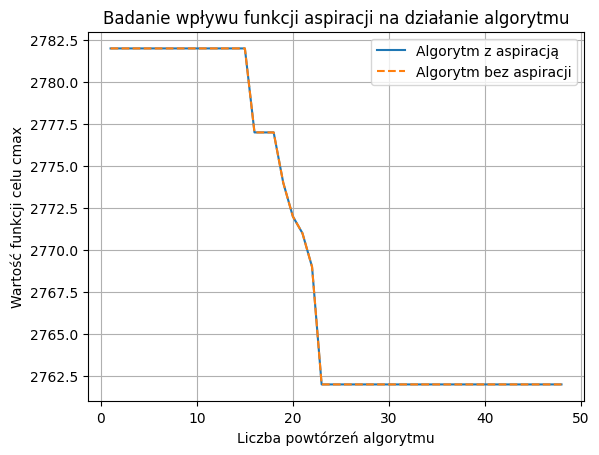

stop
stop


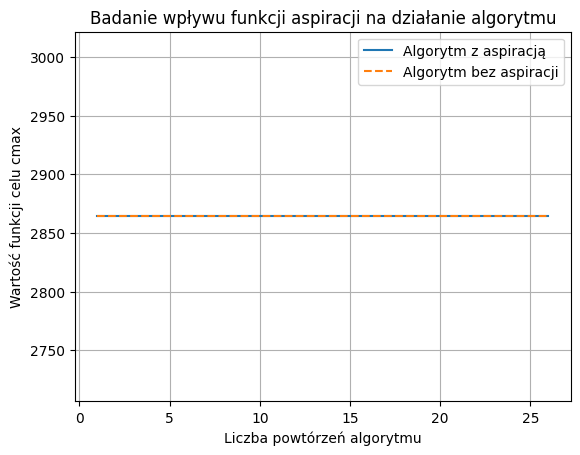

stop
stop


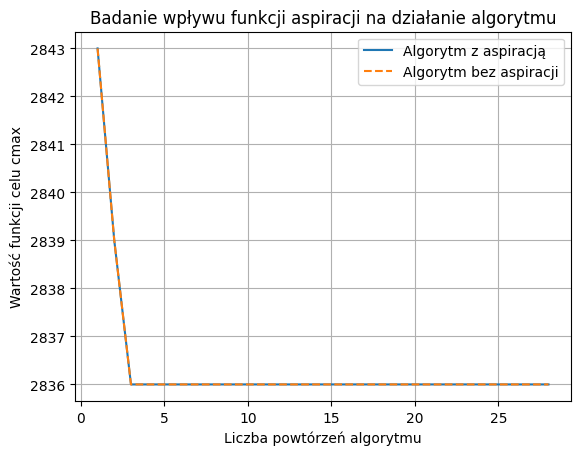

stop
stop


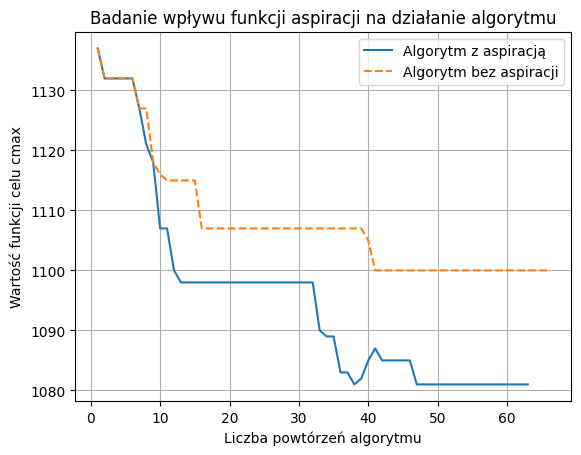

stop
stop


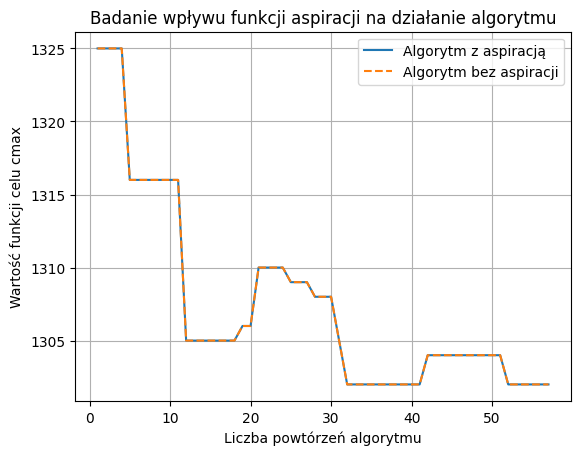

stop
stop


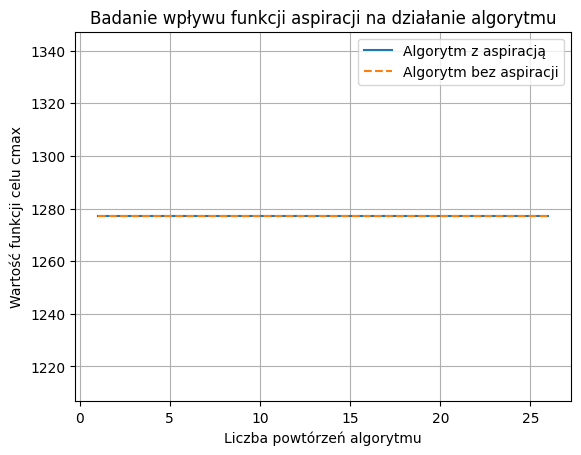

stop
stop


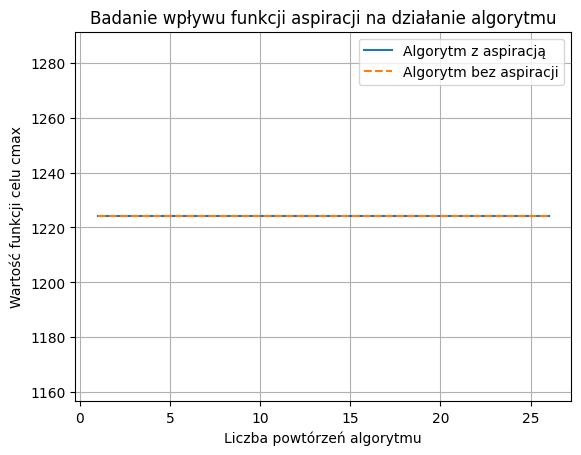

stop
stop


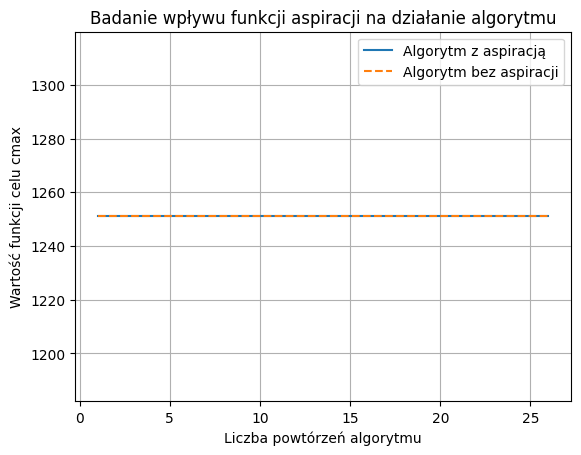

stop
stop


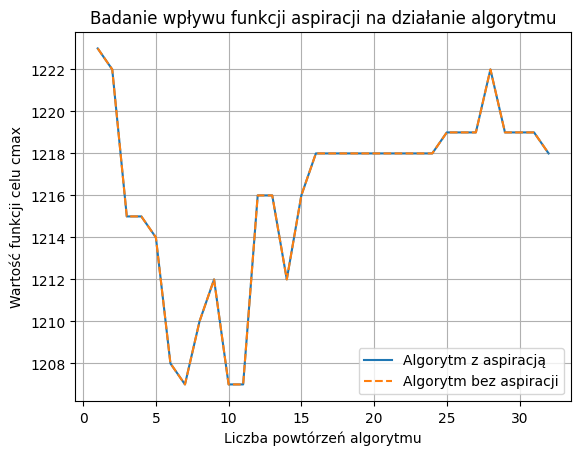

stop
stop


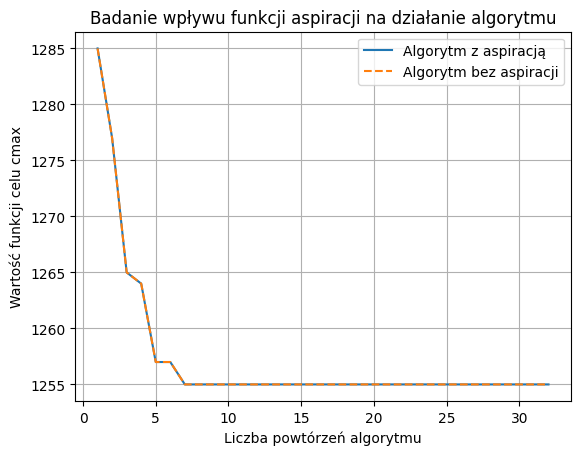

In [58]:
#BADANIE 3
#PORÓWNANIE WPŁYWU FUNKCJI ASPIRACJI
#1 - aspiracja
#2 - bez aspiracji

max_epochs=100
tabuValue= 7
epochs=25
buffer1=[]
buffer2=[]
for i in range(1, 11):
    data = ReadData("data."+str(i))
    buffer1.clear()
    buffer2.clear()
    perm, buffer1 = TabuSearch(data, max_epochs, tabuValue, epochs, True)
    perm, buffer2 = TabuSearch(data, max_epochs, tabuValue, epochs, False)
    plt.figure()
    plt.plot(range(1,len(buffer1)+1), buffer1)
    plt.plot(range(1,len(buffer2)+1), buffer2, linestyle='--')
    plt.title("Badanie wpływu funkcji aspiracji na działanie algorytmu")
    plt.legend(["Algorytm z aspiracją", "Algorytm bez aspiracji"])
    plt.xlabel("Liczba powtórzeń algorytmu")
    plt.ylabel("Wartość funkcji celu cmax")
    plt.grid()
    plt.show()

